In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import stanford_mir; stanford_mir.init()

[&larr; Back to Index](index.html)

# Audio Representation

In performance, musicians convert sheet music representations into **sound** which is transmitted through the air as air pressure oscillations. In essence, sound is simply air vibrating ([Wikipedia](https://en.wikipedia.org/wiki/Sound)).  Sound vibrates through the air as **longitudinal waves**, i.e. the oscillations are parallel to the direction of propagation.

**Audio** refers to the production, transmission, or reception of sounds that are audible by humans. An **audio signal** is a representation of sound that represents the fluctuation in air pressure caused by the vibration as a function of time. Unlike sheet music or symbolic representations, audio representations encode everything that is necessary to reproduce an acoustic realization of a piece of music. However, note parameters such as onsets, durations, and pitches are not encoded explicitly. This makes converting from an audio representation to a
symbolic representation a difficult and ill-defined task.

## Waveforms and the Time Domain

The basic representation of an audio signal is in the **time domain**. 

Let's listen to a file:

In [2]:
x, sr = librosa.load('audio/c_strum.wav')
ipd.Audio(x, rate=sr)

(If you get an error using `librosa.load`, you may need to [install ffmpeg](https://librosa.github.io/librosa/install.html#ffmpeg).)

The change in air pressure at a certain time is graphically represented by a **pressure-time plot**, or simply **waveform**.

To plot a waveform, use [`librosa.display.waveplot`](http://bmcfee.github.io/librosa/generated/librosa.display.waveplot.html):

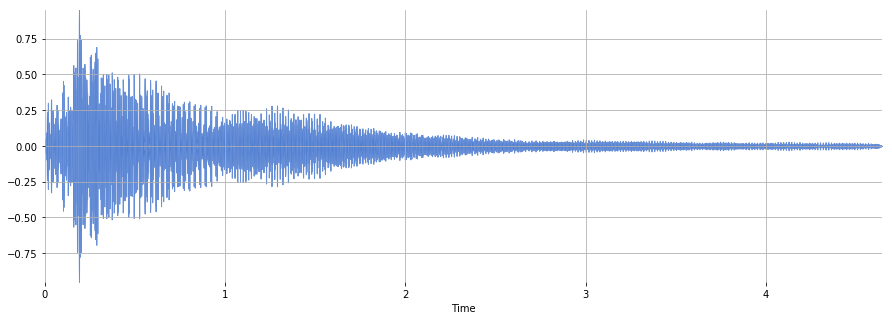

In [3]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr, alpha=0.8)

Digital computers can only capture this data at discrete moments in time. The rate at which a computer captures audio data is called the **sampling frequency** (often abbreviated `fs`) or **sampling rate** (often abbreviated `sr`). For this workshop, we will mostly work with a sampling frequency of 44100 Hz, the sampling rate of CD recordings.

## Timbre: Temporal Indicators

**Timbre** is the quality of sound that distinguishes the tone of different instruments and voices even if the sounds have the same pitch and loudness.

## Adding Tones

Watch this video up to the 2 minute mark.

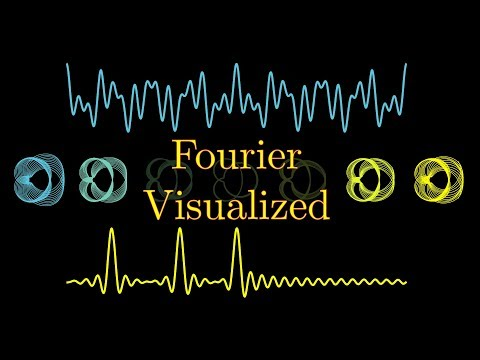

In [53]:
yt_vid = "spUNpyF58BY"
from IPython.lib.display import YouTubeVideo
YouTubeVideo(yt_vid, start = 48, stop = 120)

### Pure Tone

Let's synthesize a pure tone at 1047 Hz, concert C6:

In [4]:
T = 2.0 # seconds
f0 = 1047.0
sr = 22050
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.1*numpy.sin(2*numpy.pi*f0*t)
ipd.Audio(x, rate=sr)

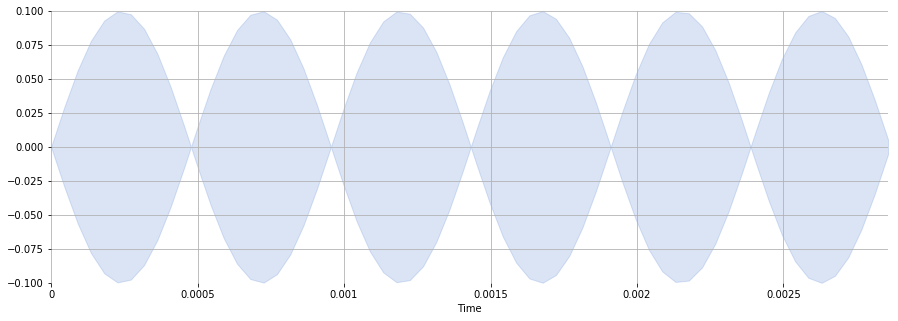

In [5]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x[:64], sr, alpha=0.2)

## A Pure Tone Function

In [7]:
def make_pitch(f0, T = 2.0, sr = 22050):
    t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
    x = 0.1*numpy.sin(2*numpy.pi*f0*t)
    return (x, sr)

## Mixing Tone by Adding Waves

Let's recreate the waves shown in the first few minutes of the video.

In [8]:
a440, sr = make_pitch(440.0)
d291, sr = make_pitch(294.0)
mix = a440 + d291
ipd.Audio(mix, rate=sr)

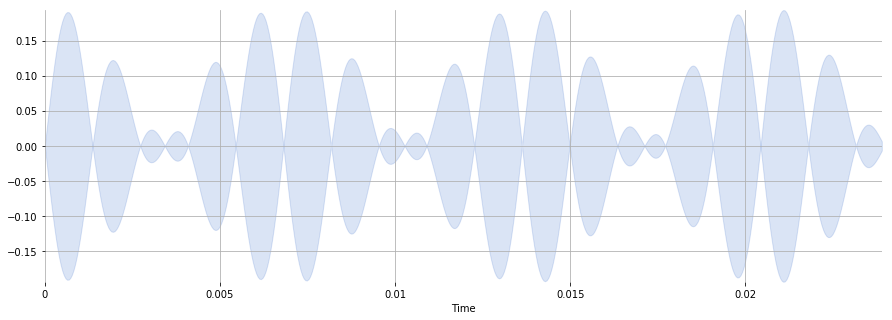

In [9]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(mix[:528 ], sr, alpha=0.2)

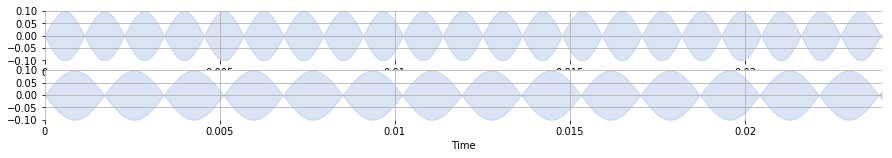

In [37]:
def make_wave_plots(*args, lower = 0, upper = 528, alpha = 0.2):
    """ Makes stacked wave plots for each of the arguments.
    
    args - an number of numpy array's from audio wav files."""
    n = len(args)
    fig = plt.figure(figsize=(15, n))
    for i, seq in enumerate(args):
        plt.subplot(n, 1, i + 1)
        librosa.display.waveplot(seq[lower:upper], sr, alpha=alpha)
    return fig
fig = make_wave_plots(a440, d291)

In [11]:
f349, sr = make_pitch(349.0)
c523, sr = make_pitch(523.0)
mix2 = mix + f349 + c523
ipd.Audio(mix2, rate=sr)

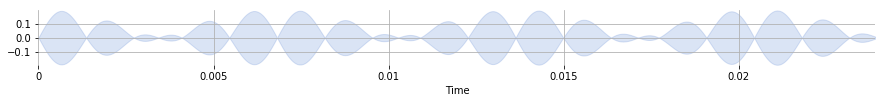

In [39]:
_ = make_wave_plots(mix)

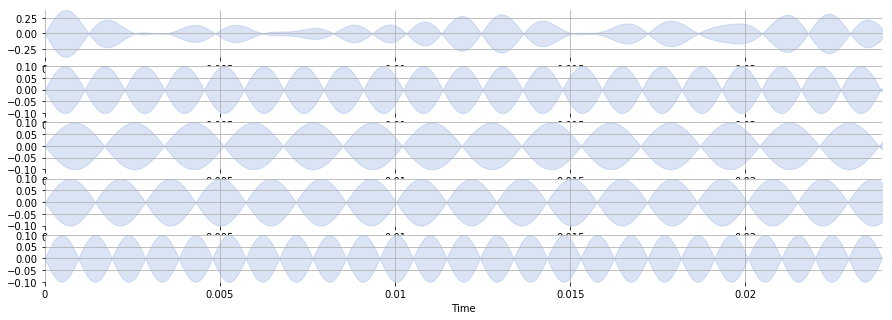

In [40]:
_ = make_wave_plots(mix2, a440, d291, f349, c523)

## Plotting in the Frequency Domain

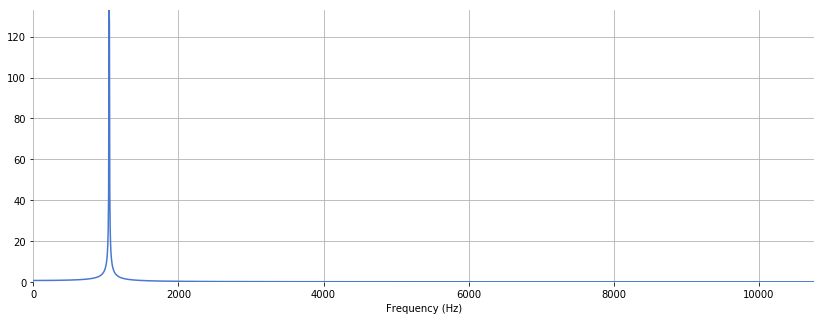

In [60]:
X = scipy.fft(x[:4096])
X_mag = numpy.absolute(X)        # spectral magnitude
f = numpy.linspace(0, sr, 4096)  # frequency variable
plt.figure(figsize=(14, 5))
plt.plot(f[:2000], X_mag[:2000]) # magnitude spectrum
plt.xlabel('Frequency (Hz)')

In [62]:
def freq_plot(x, low = 0, high = 4096):
    X = scipy.fft(x[low:high])
    X_mag = numpy.absolute(X)        # spectral magnitude
    f = numpy.linspace(0, sr, high)  # frequency variable
    p = plt.plot(f[:2000], X_mag[:2000]) # magnitude spectrum
    return p

def make_freq_plots(*args, low = 0, high = 4096):
    n = len(args)
    fig = plt.figure(figsize=(15, n))
    plt.xlabel('Frequency (Hz)')
    for i, seq in enumerate(args):
        plt.subplot(n, 1, i + 1)
        freq_plot(seq, low = low, high = high)
    return fig

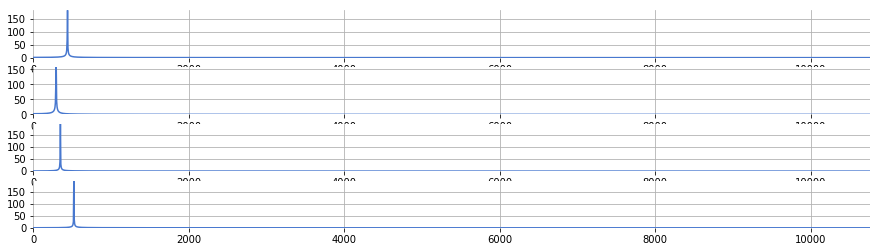

In [66]:
_ = make_freq_plots(a440, d291, f349, c523)

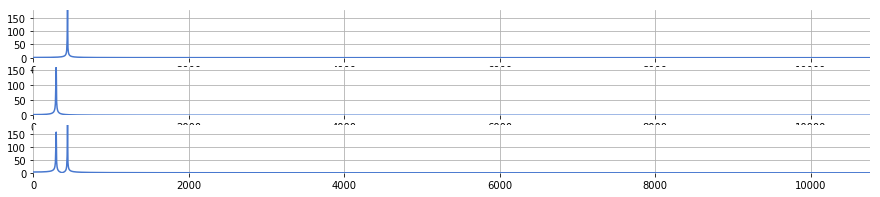

In [46]:
_ = make_freq_plots(a440, d291, mix)

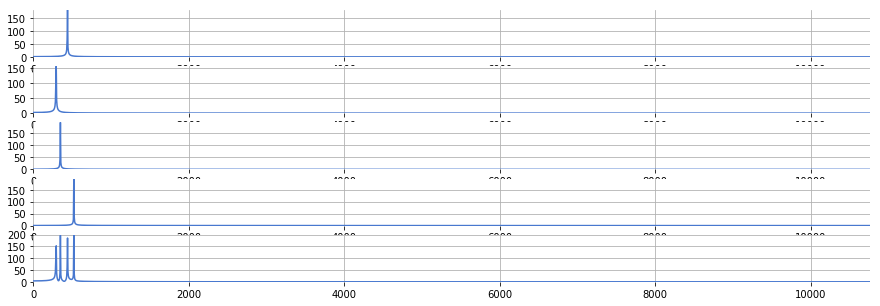

In [47]:
_ = make_freq_plots(a440, d291, f349, c523, mix2)

One characteristic of timbre is its temporal evolution. The **envelope** of a signal is a smooth curve that approximates the amplitude extremes of a waveform over time.

Envelopes are often modeled by the **ADSR model** ([Wikipedia](https://en.wikipedia.org/wiki/Synthesizer#Attack_Decay_Sustain_Release_.28ADSR.29_envelope)) which describes four phases of a sound: attack, decay, sustain, release. 

During the attack phase, the sound builds up, usually with noise-like components over a broad frequency range. Such a noise-like short-duration sound at the start of a sound is often called a transient.

During the decay phase, the sound stabilizes and reaches a steady periodic pattern.

During the sustain phase, the energy remains fairly constant.

During the release phase, the sound fades away.

The ADSR model is a simplification and does not necessarily model the amplitude envelopes of all sounds.

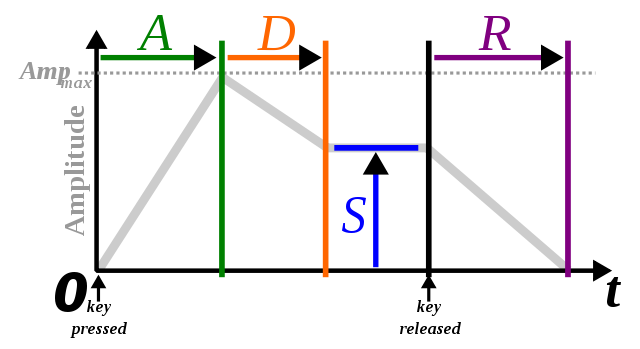

In [17]:
ipd.Image("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/ADSR_parameter.svg/640px-ADSR_parameter.svg.png")

## Timbre: Spectral Indicators

Another property used to characterize timbre is the existence of partials and their relative strengths. **Partials** are the dominant frequencies in a musical tone with the lowest partial being the **fundamental frequency**.

The partials of a sound are visualized with a **spectrogram**. A spectrogram shows the intensity of frequency components over time. (See [Fourier Transform](fourier_transform.html) and [Short-Time Fourier Transform](stft.html) for more.)

### Oboe

Let's listen to an oboe playing a C6:

In [48]:
oboe, sr = librosa.load('audio/oboe_c6.wav')
ipd.Audio(oboe, rate=sr)

In [49]:
oboe.shape

(23625,)

Display the spectrum of the oboe:

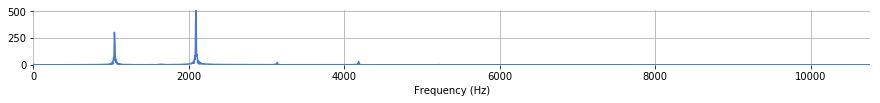

In [52]:
_ = make_freq_plots(oboe)

### Clarinet

Let's listen to a clarinet playing a concert C6:

In [54]:
clarinet, sr = librosa.load('audio/clarinet_c6.wav')
ipd.Audio(clarinet, rate=sr)

In [55]:
clarinet.shape

(51386,)

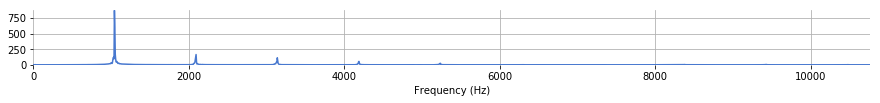

In [57]:
_ = make_freq_plots(clarinet)

Notice the difference in the relative amplitudes of the partial components. All three signals have approximately the same pitch and fundamental frequency, yet their timbres differ.

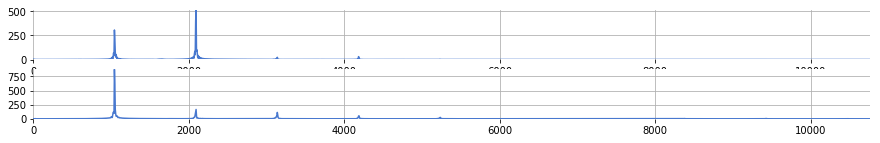

In [59]:
_ = make_freq_plots(oboe, clarinet)

[&larr; Back to Index](index.html)